In [23]:
%matplotlib inline
import pandas as pd
from scipy import stats
import matplotlib.pylab as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Load the counts matrix
counts_file = '../data/human_sub.csv'
counts = pd.read_csv(counts_file,sep=',',index_col=0)
# rows are gene IDs, columns are cell barcodes


In [3]:
# determine sample labels
labels_file = '../data/CBMC_ADT_clr_filtered.csv'
labels = pd.read_csv(labels_file,sep=',',index_col=0)
# rows are cell surface markers, columns are cell barcodes

In [6]:
# Transpose the labels and counts to be in standard format (observations as rows, features as columns)
labels = labels.T
counts = counts.T

In [11]:
# Split into train/test. For proof-of-concept, we'll pick 75/25, and regress on CD14 protein levels.
X = counts.copy()
y = labels['CD14'].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [14]:
# How does a linear regressor do? Let's train an SVM regressor.
clf = svm.SVR(kernel='linear').fit(X_train, y_train)

In [15]:
clf.score(X_test,y_test)

0.58771147767065646

In [16]:
# R^2 is 0.58, so the linear regressor is pretty bad... let's try a non-linear kernel in the SVM.
clf_rbf = svm.SVR(kernel='rbf').fit(X_train, y_train)

In [17]:
clf_rbf.score(X_test,y_test)

0.80489733528069773

In [27]:
# The non-linear SVM performed better, but training took a while. Let's try a random forest
rf_regress = RandomForestRegressor(n_estimators=100,min_samples_split=10).fit(X_train, y_train)

In [28]:
rf_regress.score(X_test,y_test)

0.84406464975857343

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb3acdf0550>]], dtype=object)

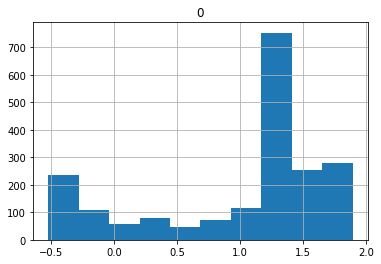

In [34]:
# A little bit better, and it will be easier to interpret feature importances.

# First, does the distribution of predicted CD14 protein values match the distribution in the test?
# This will tell us if the regressor is just guessing a particular value for every sample to minimize error.
pd.DataFrame(rf_regress.predict(X_test)).hist()

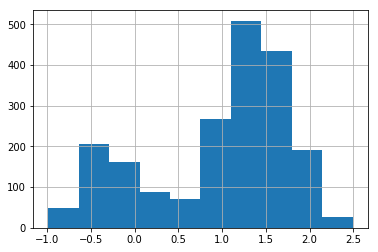

In [36]:
# Looks like a decent match.
y_test.hist()

In [85]:
# examine the features that contribute to predictive performance.
# Values sum to 1, and higher values indicate a more predictive feature.
feature_imps = pd.DataFrame()
feature_imps['importance'] = rf_regress.feature_importances_
feature_imps.index = X.columns
feature_imps.sort_values(by='importance',ascending=False)

,importance
HUMAN_NKG7,0.364087
HUMAN_S100A8,0.088225
HUMAN_CD8A,0.049820
HUMAN_IGHM,0.046726
HUMAN_CD8B,0.044654
HUMAN_LYZ,0.043052
HUMAN_S100A9,0.040911
HUMAN_CD74,0.030444
HUMAN_CTSW,0.023265
HUMAN_RPS18,0.009928


In [57]:
# interestingly, the CD14 transcript is a very poor predictor of CD14 protein.
feature_imps.loc['HUMAN_CD14',]

importance    0.000093
Name: HUMAN_CD14, dtype: float64

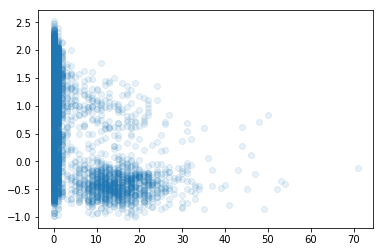

In [59]:
# What is the relationship between the marker value and the most important features?
fix,ax = plt.subplots()
ax.scatter(x=X['HUMAN_NKG7'],y=y,alpha = 0.1)

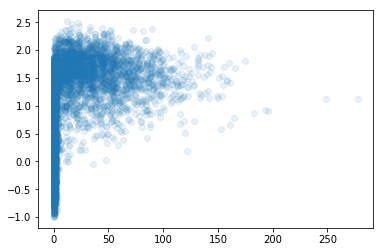

In [54]:
# plot the next most important feature the same way
fix,ax = plt.subplots()
ax.scatter(x=X['HUMAN_S100A8'],y=y,alpha = 0.1)

(-0.66151996676089897, 2.0305570889789042)

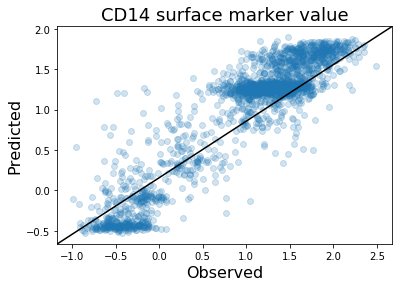

In [84]:
# Let's inspect the observed vs. predicted values visually
fix,ax = plt.subplots()
ax.scatter(x=y_test,y=rf_regress.predict(X_test),alpha = 0.2)
old_xlim = ax.get_xlim()
old_ylim = ax.get_ylim()
ax.plot([ax.get_xlim()[0],ax.get_xlim()[1]],[ax.get_ylim()[0],ax.get_ylim()[1]],c='black')
ax.set_title('CD14 surface marker value',size=18)
ax.set_xlabel('Observed',size=16)
ax.set_ylabel('Predicted',size=16)
ax.set_xlim(old_xlim)
ax.set_ylim(old_ylim)